Implementing the Quanvolutional Neural Networks as introduced in Henderson et al. (2019).

In [4]:
import pennylane as qml
from pennylane import numpy as np
from pennylane.templates import RandomLayers
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt


Setting the main hyper-parameters of the model.

In [5]:
n_epochs = 30   # Number of optimization epochs
n_layers = 1    # Number of random layers
n_train = 50    # Size of the train dataset
n_test = 30     # Size of the test dataset

SAVE_PATH = "../_static/demonstration_assets/quanvolution/"  # Data saving folder
PREPROCESS = True           # If False, skip quantum processing and load data from SAVE_PATH
np.random.seed(0)           # Seed for NumPy random number generator
tf.random.set_seed(0)       # Seed for TensorFlow random number generator


Downloading MNIST dataset using Keras.

In [6]:
mnist_dataset = keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist_dataset.load_data()

# Reduce dataset size
train_images = train_images[:n_train]
train_labels = train_labels[:n_train]
test_images = test_images[:n_test]
test_labels = test_labels[:n_test]

# Normalize pixel values within 0 and 1
train_images = train_images / 255
test_images = test_images / 255

# Add extra dimension for convolution channels
train_images = np.array(train_images[..., tf.newaxis], requires_grad=False)
test_images = np.array(test_images[..., tf.newaxis], requires_grad=False)

Creating a system of 4 qubits and quantum circuit comprising of an embedded layer of Ry rotations, a random circuit and a final measurement in the computational basis.

In [7]:
dev = qml.device("default.qubit", wires=4)
# Random circuit parameters
rand_params = np.random.uniform(high=2 * np.pi, size=(n_layers, 4))

@qml.qnode(dev)
def circuit(phi):
    # Encoding of 4 classical input values
    for j in range(4):
        qml.RY(np.pi * phi[j], wires=j)

    # Random quantum circuit
    RandomLayers(rand_params, wires=list(range(4)))

    # Measurement producing 4 classical output values
    return [qml.expval(qml.PauliZ(j)) for j in range(4)]

Setting up the convolution scheme:
    1)The image is split into small 2x2 pixel squares
    2)Each square is processed by the quantum circuit.
    3)The 4 values obtained from each square are used to create 4 different channels for a single output pixel.

In [8]:
def quanv(image):
    """Convolves the input image with many applications of the same quantum circuit."""
    out = np.zeros((14, 14, 4))

    # Loop over the coordinates of the top-left pixel of 2X2 squares
    for j in range(0, 28, 2):
        for k in range(0, 28, 2):
            # Process a squared 2x2 region of the image with a quantum circuit
            q_results = circuit(
                [
                    image[j, k, 0],
                    image[j, k + 1, 0],
                    image[j + 1, k, 0],
                    image[j + 1, k + 1, 0]
                ]
            )
            # Assign expectation values to different channels of the output pixel (j/2, k/2)
            for c in range(4):
                out[j // 2, k // 2, c] = q_results[c]
    return out

Since we won't be training the quantum convolution layer, it's better to use it as a "pre-processing" step for all the images in our dataset. After this, we'll train and test a fully classical model using the pre-processed images, which avoids repeating the quantum computations.

In [9]:
if PREPROCESS == True:
    q_train_images = []
    print("Quantum pre-processing of train images:")
    for idx, img in enumerate(train_images):
        print("{}/{}        ".format(idx + 1, n_train), end="\r")
        q_train_images.append(quanv(img))
    q_train_images = np.asarray(q_train_images)

    q_test_images = []
    print("\nQuantum pre-processing of test images:")
    for idx, img in enumerate(test_images):
        print("{}/{}        ".format(idx + 1, n_test), end="\r")
        q_test_images.append(quanv(img))
    q_test_images = np.asarray(q_test_images)

    # Save pre-processed images
    np.save(SAVE_PATH + "q_train_images.npy", q_train_images)
    np.save(SAVE_PATH + "q_test_images.npy", q_test_images)


# Load pre-processed images
q_train_images = np.load(SAVE_PATH + "q_train_images.npy")
q_test_images = np.load(SAVE_PATH + "q_test_images.npy")

Quantum pre-processing of train images:
50/50        
Quantum pre-processing of test images:


Visualizing the effect of convolutional layer on a batch of samples.

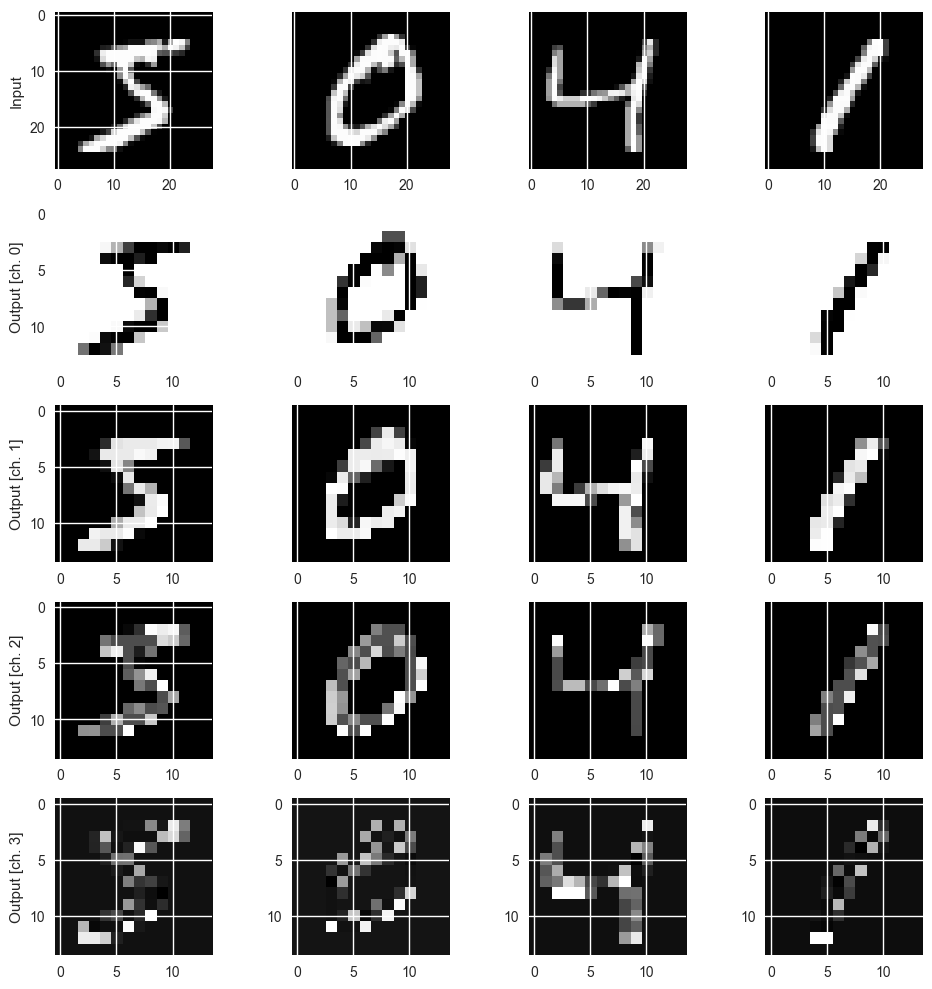

In [11]:
n_samples = 4
n_channels = 4
fig, axes = plt.subplots(1 + n_channels, n_samples, figsize=(10, 10))
for k in range(n_samples):
    axes[0, 0].set_ylabel("Input")
    if k != 0:
        axes[0, k].yaxis.set_visible(False)
    axes[0, k].imshow(train_images[k, :, :, 0], cmap="gray")

    # Plot all output channels
    for c in range(n_channels):
        axes[c + 1, 0].set_ylabel("Output [ch. {}]".format(c))
        if k != 0:
            axes[c, k].yaxis.set_visible(False)
        axes[c + 1, k].imshow(q_train_images[k, :, :, c], cmap="gray")

plt.tight_layout()
plt.show()



We see that the image resolution is reduced and some local distortion is caused by the quantum kernel. However, the overall shape of the image remains intact, which is what you'd expect from a convolution layer.

After the application of the quantum convolution layer we feed the resulting features into a classical neural network that will be trained to classify the 
1   different digits of the MNIST datase We do so by a very simple model consisting of a fully connected layer of 10 output nodes with a final softmax activation function.t.

In [12]:
def MyModel():
    """Initializes and returns a custom Keras model
    which is ready to be trained."""
    model = keras.models.Sequential([
        keras.layers.Flatten(),
        keras.layers.Dense(10, activation="softmax")
    ])

    model.compile(
        optimizer='adam',
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )
    return model

First, we create an instance of the model, then we train and validate it using the dataset that has already been pre-processed with a quantum convolution.

In [13]:
q_model = MyModel()

q_history = q_model.fit(
    q_train_images,
    train_labels,
    validation_data=(q_test_images, test_labels),
    batch_size=4,
    epochs=n_epochs,
    verbose=2,
)

Epoch 1/30
13/13 - 1s - 82ms/step - accuracy: 0.1000 - loss: 2.8225 - val_accuracy: 0.2333 - val_loss: 2.2841
Epoch 2/30
13/13 - 0s - 11ms/step - accuracy: 0.2000 - loss: 2.1064 - val_accuracy: 0.3000 - val_loss: 2.0845
Epoch 3/30
13/13 - 0s - 10ms/step - accuracy: 0.4600 - loss: 1.7585 - val_accuracy: 0.3667 - val_loss: 1.9107
Epoch 4/30
13/13 - 0s - 10ms/step - accuracy: 0.6000 - loss: 1.4308 - val_accuracy: 0.4667 - val_loss: 1.7628
Epoch 5/30
13/13 - 0s - 10ms/step - accuracy: 0.9200 - loss: 1.1818 - val_accuracy: 0.4333 - val_loss: 1.6431
Epoch 6/30
13/13 - 0s - 11ms/step - accuracy: 0.9400 - loss: 0.9756 - val_accuracy: 0.4667 - val_loss: 1.5512
Epoch 7/30
13/13 - 0s - 12ms/step - accuracy: 0.9600 - loss: 0.8157 - val_accuracy: 0.5000 - val_loss: 1.4747
Epoch 8/30
13/13 - 0s - 10ms/step - accuracy: 0.9600 - loss: 0.6881 - val_accuracy: 0.5667 - val_loss: 1.4099
Epoch 9/30
13/13 - 0s - 11ms/step - accuracy: 0.9800 - loss: 0.5856 - val_accuracy: 0.6000 - val_loss: 1.3567
Epoch 10/3

To compare the results with and without the quantum convolution layer, we also set up a classical version of the model. This classical model will be trained and validated directly using the raw MNIST images.

In [14]:
c_model = MyModel()

c_history = c_model.fit(
    train_images,
    train_labels,
    validation_data=(test_images, test_labels),
    batch_size=4,
    epochs=n_epochs,
    verbose=2,
)

Epoch 1/30
13/13 - 1s - 70ms/step - accuracy: 0.2200 - loss: 2.2697 - val_accuracy: 0.1333 - val_loss: 2.1867
Epoch 2/30
13/13 - 0s - 10ms/step - accuracy: 0.3800 - loss: 1.9015 - val_accuracy: 0.3000 - val_loss: 2.0225
Epoch 3/30
13/13 - 0s - 12ms/step - accuracy: 0.6200 - loss: 1.6300 - val_accuracy: 0.4667 - val_loss: 1.8720
Epoch 4/30
13/13 - 0s - 10ms/step - accuracy: 0.7800 - loss: 1.3989 - val_accuracy: 0.6333 - val_loss: 1.7408
Epoch 5/30
13/13 - 0s - 8ms/step - accuracy: 0.8800 - loss: 1.2039 - val_accuracy: 0.6667 - val_loss: 1.6308
Epoch 6/30
13/13 - 0s - 8ms/step - accuracy: 0.9200 - loss: 1.0413 - val_accuracy: 0.7000 - val_loss: 1.5401
Epoch 7/30
13/13 - 0s - 8ms/step - accuracy: 0.9400 - loss: 0.9061 - val_accuracy: 0.7000 - val_loss: 1.4656
Epoch 8/30
13/13 - 0s - 9ms/step - accuracy: 0.9400 - loss: 0.7935 - val_accuracy: 0.7000 - val_loss: 1.4038
Epoch 9/30
13/13 - 0s - 9ms/step - accuracy: 0.9800 - loss: 0.6993 - val_accuracy: 0.6667 - val_loss: 1.3520
Epoch 10/30
13/

We can finally plot the test accuracy and the test loss with respect to the number of training epochs.
Epochs is the total number of times the entire training dataset is passed through the model during training.

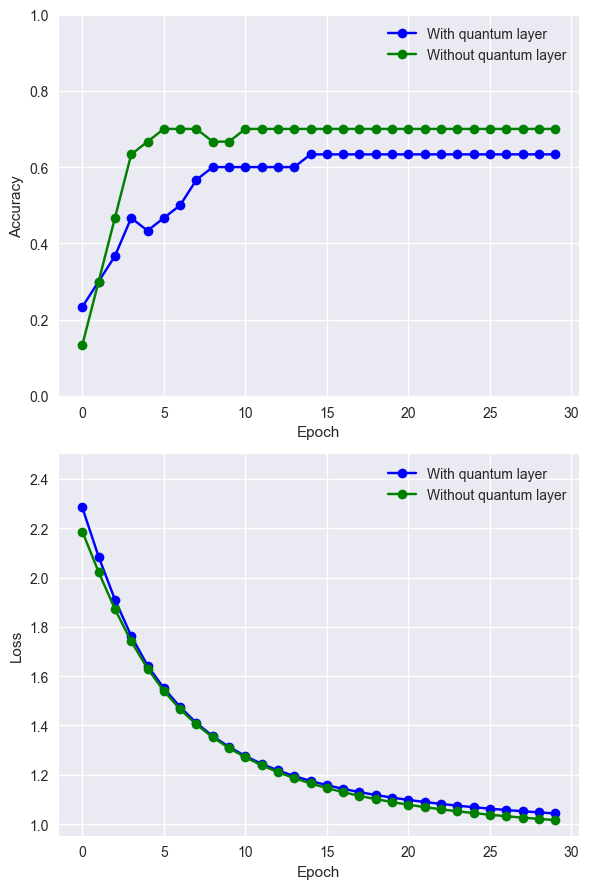

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-v0_8')
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 9))

ax1.plot(q_history.history["val_accuracy"], "-ob", label="With quantum layer")
ax1.plot(c_history.history["val_accuracy"], "-og", label="Without quantum layer")
ax1.set_ylabel("Accuracy")
ax1.set_ylim([0, 1])
ax1.set_xlabel("Epoch")
ax1.legend()

ax2.plot(q_history.history["val_loss"], "-ob", label="With quantum layer")
ax2.plot(c_history.history["val_loss"], "-og", label="Without quantum layer")
ax2.set_ylabel("Loss")
ax2.set_ylim(top=2.5)
ax2.set_xlabel("Epoch")
ax2.legend()
plt.tight_layout()
plt.show()